In [19]:
import pathlib
from src.models.cmu_mosei_module import CmuMoseiModule
import torch

notebook_folder = pathlib.Path().resolve()
project_folder = notebook_folder.parent
data_folder = project_folder / "best_models" / "best_text_model"
test_text_model_checkpoint = str(data_folder)

device = torch.device("cpu" if torch.cpu.is_available() else "mps")
model = CmuMoseiModule.load_from_checkpoint(test_text_model_checkpoint).to(device)
model.eval()


/Users/felixachter/source/github/ml_and_ai/lightning-hydra-wandb-starter/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


CmuMoseiModule(
  (model): EmotionClassifier(
    (embedding_creator): GloveEmotionEmbeddingCreator(
      (convs): ModuleList(
        (0): Conv2d(1, 20, kernel_size=(3, 300), stride=(1, 1))
        (1): Conv2d(1, 20, kernel_size=(4, 300), stride=(1, 1))
        (2): Conv2d(1, 20, kernel_size=(5, 300), stride=(1, 1))
      )
    )
    (classifier): Classifier(
      (fc): Sequential(
        (0): Dropout(p=0.3, inplace=False)
        (1): Linear(in_features=60, out_features=16, bias=True)
        (2): Sigmoid()
        (3): Linear(in_features=16, out_features=7, bias=True)
      )
    )
  )
  (criterion): CrossEntropyLoss()
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (val_acc_best): MaxMetric()
  (val_f1_best): MaxMetric()
  (val_confmat_best): MaxMetric()
  (val_f1): MulticlassF1Score()
  (val_confmat): MulticlassConfusionMatrix()
  (test_f1): MulticlassF1Score()
  (test_confmat): MulticlassConfusionMatrix()
)

In [20]:
import torch

notebook_folder = pathlib.Path().resolve()
project_folder = notebook_folder.parent
data_folder = project_folder / "data" / "aligned_glove_vectors_data"
test_data_file = data_folder / "normalized_test_data.pkl"
test_labels_file = data_folder / "normalized_test_labels.pkl"
with open(test_data_file, "rb") as f:
    text_test_features = torch.load(f)
with open(test_labels_file, "rb") as f:
    text_test_labels = torch.load(f)

In [21]:
from src.data.components.text_dataset import TextDataset
from torch.utils.data import DataLoader

test_dataset = TextDataset(glove_data=text_test_features, labels=text_test_labels)
test_loader = DataLoader(test_dataset, batch_size=64)

In [22]:
all_test_predictions = []
all_test_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        _, predictions, labels = model.model_step(batch)
        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

/Users/felixachter/source/github/ml_and_ai/lightning-hydra-wandb-starter/src/data/components/text_dataset.py:25: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/felixachter/source/github/ml_and_ai/lightning-hydra-wandb-starter/src/data/components/text_dataset.py:29: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


<Figure size 800x600 with 0 Axes>

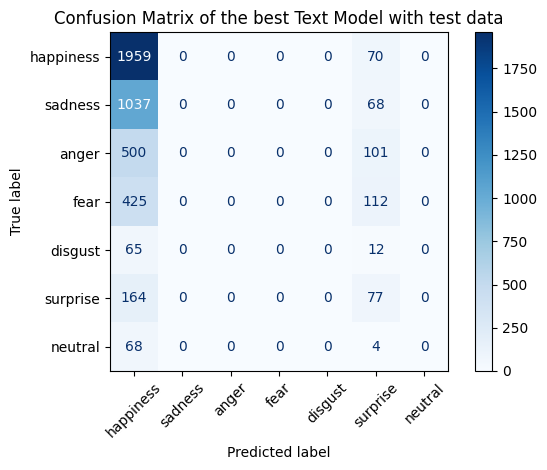

In [24]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ["happiness", "sadness", "anger", "fear", "disgust", "surprise", "neutral"]

cm = confusion_matrix(all_test_labels, all_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix of the best text model with test data")
plt.grid(False)
plt.tight_layout()
plt.show()